# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
* Контролировать добросовестность кассиров при продаже алкоголя.  

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.  
В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Импорт необходимых библиотек

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

### Загрузка данных

1. Произведем загрузку данных с реальным возрастом людей с фото 

2. Далее ImageDataGenerator сформирует батчи с изображениями и метками классов
    - При этом произведем нормировку яркости: поделим на 255  


3. Произведем извлечение данных с фотографиями людей из папки по адресу прописанному в directory  
    - Определим размер батча = 32 и размер таргета 224х224

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Получим пары «картинки — метки» обучающего набора данных при помощи функции next():

In [4]:
features_train, target_train = next(train_gen_flow)
features_train.shape

(32, 224, 224, 3)

Это означает, что в выборку попали 32 изображения размером 224x224 с 3 цветовыми каналами

Посмотрим на первые 5 строк и на общую информацию по таблице с реальным возрастом:

In [38]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [39]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные не содержат пропусков и имеют корректный тип

Построим график распределения возраста в выборке:

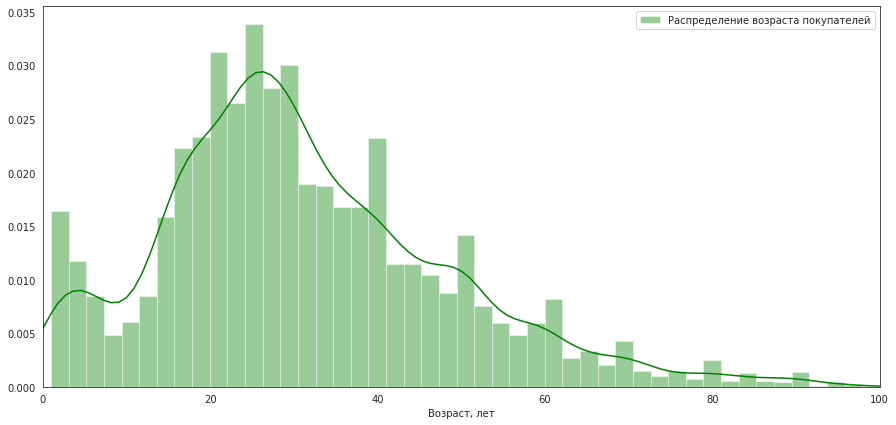

In [34]:
age =  labels['real_age']

sns.set_style("white")
plt.figure(figsize=(15,7))
sns.distplot(age, color="g", label="Распределение возраста покупателей")
plt.xlabel("Возраст, лет")
plt.xlim(0,100)
plt.legend();

По графику можно отметить два четких всплеска в возрастных категориях 0-3 года и 20-30 лет.

Выведем 12 изображений людей с их возрастом в title:

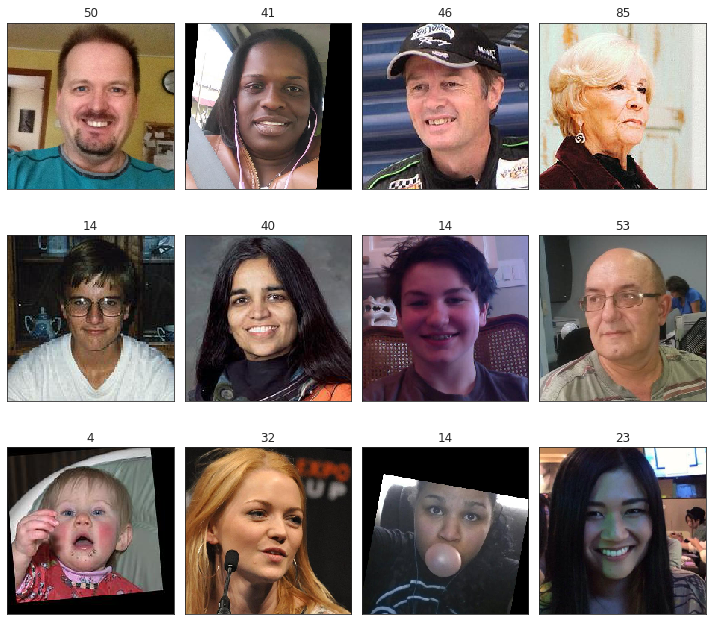

In [49]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features_train[i])
    plt.title(target_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

В рамках проведенного исследования полученных данных, мы можем утверждать что они хорошо подходят нам для обучения модели, т.к. в выборку попали люди всех возрастов в достаточном количестве в соответствии с реальностью.

Изображения имеют размер 224x224 и 3 цветовых канала. Некоторые из них имеют небольшой угол поворота, что не должно повредить обучению.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2021-08-29 11:33:08.890244: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-08-29 11:33:09.284101: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 97s - loss: 205.8937 - mae: 10.9337 - val_loss: 317.7469 - val_mae: 13.2171
Epoch 2/20
356/356 - 38s - loss: 132.2549 - mae: 8.8003 - val_loss: 207.9732 - val_mae: 11.3323
Epoch 3/20
356/356 - 38s - loss: 111.3687 - mae: 8.0542 - val_loss: 220.6903 - val_mae: 12.4476
Epoch 4/20
356/356 - 38s - loss: 96.0990 - mae: 7.4602 - val_loss: 130.7575 - val_mae: 8.6687
Epoch 5/20
356/356 - 38s - loss: 80.8075 - mae: 6.8682 - val_loss: 114.8564 - val_mae: 7.9154
Epoch 6/20
356/356 - 38s - loss: 63.2104 - mae: 6.1622 - val_loss: 99.9444 - val_mae: 7.5775
Epoch 7/20
356/356 - 38s - loss: 56.8717 - mae: 5.7539 - val_loss: 98.5599 - val_mae: 7.5291
Epoch 8/20
356/356 - 38s - loss: 48.3308 - mae: 5.3532 - val_loss: 118.5417 - val_mae: 8.0425
Epoch 9/20
356/356 - 37s - loss: 44.7809 - mae: 5.1112 - val_loss: 108.0409 - val_mae: 8.2764
Epoch 10/20
356/356 - 38s - loss: 37.7357 - mae: 4.7835 - val_loss: 123.3232 - val_mae: 8.6573
Epoch 11/20
356/356 - 37s - loss: 34.1420 - mae: 4.4952 - val_loss: 93.5316 - val_mae: 7.4034
Epoch 12/20
356/356 - 38s - loss: 29.1876 - mae: 4.1798 - val_loss: 98.0399 - val_mae: 7.3855
Epoch 13/20
356/356 - 38s - loss: 25.7396 - mae: 3.9261 - val_loss: 113.6679 - val_mae: 7.6616
Epoch 14/20
356/356 - 38s - loss: 23.2058 - mae: 3.7261 - val_loss: 81.9500 - val_mae: 6.8219
Epoch 15/20
356/356 - 38s - loss: 21.9398 - mae: 3.5903 - val_loss: 94.1320 - val_mae: 7.4624
Epoch 16/20
356/356 - 37s - loss: 21.7635 - mae: 3.5894 - val_loss: 93.6277 - val_mae: 7.3730
Epoch 17/20
356/356 - 38s - loss: 20.7581 - mae: 3.5230 - val_loss: 103.5846 - val_mae: 7.5290
Epoch 18/20
356/356 - 37s - loss: 19.8681 - mae: 3.4168 - val_loss: 113.6738 - val_mae: 8.2811
Epoch 19/20
356/356 - 37s - loss: 17.1522 - mae: 3.1816 - val_loss: 89.5773 - val_mae: 7.2397
Epoch 20/20
356/356 - 38s - loss: 15.3912 - mae: 3.0327 - val_loss: 89.9370 - val_mae: 7.2274
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 89.9370 - mae: 7.2274
Test MAE: 7.2274


```

## Анализ обученной модели

Наилучшего результата удалось добиться при помощи применения архитектуры ResNet50: функция активации ReLu и 1 нейрон на выходе.  

В результате прохождения обучения модели на 20 эпохах, мы добились минимального значения MAE на тестовой выборке и оно составило 
7.2, что на 0.8 меньше (лучше) требуемого результата. 

Однако нужно отметить что определяемый диапазон возраста достаточно широк для четкого определения совершеннолетний человек или нет, поэтому не рекомендуется применять данную модель с целью возможности продажи алкоголя. 

Но модель можно удачно применять для рекомендаций товаров определенным возрастным группам, т.к. с определением возрастного диапазона она справится отлично.